# Topics and trends with word2vec

In [1]:
#Load usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import time

In [2]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv('./data/abcnews-date-text_ndates.csv')
df.head(2)

Unnamed: 0 publish_date                                      headline_text  \
0           0   2003-02-19  aba decides against community broadcasting lic...   
1           1   2003-02-19     act fire witnesses must be aware of defamation   

   year  month  day year_month  
0  2003      2   19    2003 02  
1  2003      2   19    2003 02

In [5]:
df.shape

(1103665, 7)

In [6]:
dX = pd.read_csv('./data/frac10_w2vfeat_windex.csv')

In [7]:
dX.head(2)

Unnamed: 0    feat_0    feat_1    feat_2    feat_3    feat_4    feat_5  \
0      794981 -0.041016  0.202148  0.073730  0.211914 -0.435547 -0.130619   
1     1021941 -0.268768 -0.012848 -0.556152  0.150330  0.089111 -0.261871   

     feat_6    feat_7    feat_8    ...     feat_290  feat_291  feat_292  \
0 -0.824677 -1.057617  0.510010    ...     0.095825  0.572998 -0.216309   
1 -0.218414 -0.801788  0.432947    ...    -0.497925 -0.339844 -1.482422   

   feat_293  feat_294  feat_295  feat_296  feat_297  feat_298  feat_299  
0  0.257690  0.380371  0.278320 -0.506348 -0.753204 -0.470825  0.488037  
1  1.043762 -0.292236  0.217285 -1.217339 -0.681152  0.638290  0.814963  

[2 rows x 301 columns]

In [8]:
dfm = pd.merge(dX, df, left_on='Unnamed: 0', right_index=True)
dfm.shape

(110366, 309)

In [9]:
%%notify
dfm.to_csv('./data/abc_text_date_frac10_w2vfeat_windex.csv')

<IPython.core.display.Javascript object>

## Word2vec

We are here usin the pre-trained word2vec model and the gensim library to load a google model https://code.google.com/archive/p/word2vec/

Our headlines are represented by 300 features that consist of the sum (element-wise) of their word vectors.

In [3]:
import gensim

In [4]:
#model = gensim.models.KeyedVectors.load_word2vec_format('/dev/GoogleNews-vectors-negative300.bin', binary=True)
model = gensim.models.KeyedVectors.load_word2vec_format('./google model/GoogleNews-vectors-negative300.bin', binary=True)
type(model)

gensim.models.keyedvectors.KeyedVectors

In [5]:
#df_samp = dfm.copy()
df_samp = pd.read_csv('./data/abc_text_date_frac10_w2vfeat_windex.csv')
df_samp.index = df_samp['Unnamed: 0.1']
df_samp.headline_text.loc[882416]

'indonesian terrorism expert says jihadists celebrating isis iraq'

In [6]:
dX = df_samp[[('feat_'+str(i)) for i in range(300)]]
dX = dX.dropna(how='any')
X = dX.as_matrix()
y_labels = np.zeros((len(dX.index),))

In [7]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)

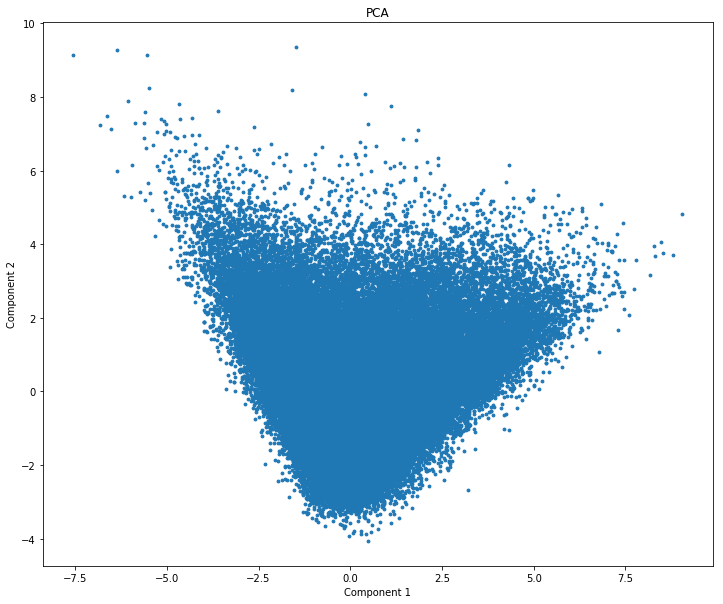

In [8]:
plt.figure(figsize=(12,10))
plt.scatter(X_t[:,0], X_t[:,1], s=8)
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [28]:
model.most_similar('terrorism', topn=20)

[('terror', 0.852210521697998),
 ('terrorist', 0.7522496581077576),
 ('Terrorism', 0.7065826654434204),
 ('terrorists', 0.6969891786575317),
 ('violent_extremism', 0.6819487810134888),
 ('extremism', 0.681633472442627),
 ('combating_terrorism', 0.6808534860610962),
 ('terorrism', 0.6579173803329468),
 ('Islamic_extremism', 0.6568551063537598),
 ('counter_terrorism', 0.6499603986740112),
 ('Islamist_extremism', 0.6441589593887329),
 ('WMD_proliferation', 0.6427096724510193),
 ('militancy', 0.6244295835494995),
 ('radical_Islam', 0.6154404878616333),
 ('Islamic_extremists', 0.6142626404762268),
 ('terrrorism', 0.6133536100387573),
 ('terrorist_attacks', 0.6094526648521423),
 ('al_Qaeda', 0.6084578037261963),
 ('counterterrorism', 0.6082285642623901),
 ('Islamic_radicalism', 0.606555700302124)]

In [9]:
"""
From a keyword, let's say a topic like terrorism or politics, we can derive the most similar words of the vocabulary
for this keyword. Then we can compute a score to assess whether the headline is related to these keywords, 
for example using the cosine similarity.

REMARK: 11 out of 20 words above are bigrams. 
Our features do not include bigrams, that's a good angle for improvements later on.

"""
key_topic = 'terrorism' # topic to choose
topn = 50 # nb of similar keywords to use

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def get_relevance_per_headline(key_topic, topn, headline_vector, keywords):
    # Compute the mean of cosine similarities
    cs_list = [cosine_similarity([headline_vector], [model[key[0]]])[0,0] for key in keywords]
    score = np.mean(cs_list)
    return score

In [11]:
# recall that dX =  df_samp[[('feat_'+str(i)) for i in range(300)]] and dX = dX.dropna(how='any')
feat_names = [('feat_' + str(ind)) for ind in range(300)]
df_samp2 = dX.copy()

def get_relevance_samp(key_topic, topn):
    keywords = model.most_similar(key_topic, topn=topn) #list of keywords similar to the key_topic
    df_ = df_samp2.copy()
    df_['vec_repr'] = df_[feat_names].values.tolist()
    df_['relevance_score'] = df_.vec_repr.apply(lambda x: get_relevance_per_headline(key_topic, topn, x, keywords))
    df_ = df_.sort_values('relevance_score', ascending=False)
    return df_

# This is really not optimized

In [12]:
%%notify
start_time = time.time()
most_relevant = get_relevance_samp(key_topic, topn)
print('Final elapsed time:', time.time() - start_time)
most_relevant.head(10)

#took 2047.5227310657501 s on the 10% of the dataset

Final elapsed time: 2047.5227310657501


feat_0    feat_1    feat_2    feat_3    feat_4    feat_5  \
Unnamed: 0.1                                                               
413637        0.347168  0.110260  0.282715  0.963623 -0.030640  0.152832   
1055052       0.353516 -0.114136  0.373169  1.561340 -1.235428 -0.128296   
808767        0.402832 -0.190674 -0.161499  1.041992 -0.708008 -0.125977   
882416       -0.040283 -0.209473 -0.082642  1.494873 -0.892464  0.702637   
288264       -0.302734  0.265991 -0.043335  0.902588 -0.912109 -0.124725   
126650       -0.063477  0.504395 -0.104767  1.162109  0.036255 -0.036377   
895232        0.867493  0.381592  1.092407  1.327957 -1.172974  0.389313   
896993        0.301819  0.038536  1.119629  1.602783 -0.744263 -0.589233   
198657       -0.169983 -0.173706  0.259644  0.908203 -0.692017 -0.001068   
950636       -0.007446 -0.246826  0.714966  1.291016 -0.893005 -0.145508   

                feat_6    feat_7    feat_8    feat_9       ...         \
Unnamed: 0.1                                               ...          
413637       -0.074219  0.263672  0.403931  0.929321       ...          
1055052      -0.224274 -0.563324  0.918945  0.482666       ...          
808767       -0.616211 -0.424194  0.184082  0.572754       ...          
882416       -0.109039 -0.987305  0.209229  0.523682       ...          
288264       -0.266907  0.371094  0.566040 -0.455627       ...          
126650       -0.380280 -0.683899 -0.314529  0.970703       ...          
895232       -0.235718  0.570251  1.078369  0.446899       ...          
896993       -1.393555  0.070862  0.732468  1.463623       ...          
198657       -0.516357 -0.151367  0.713379  0.626831       ...          
950636       -0.933533 -0.780273  0.503662  1.024872       ...          

              feat_292  feat_293  feat_294  feat_295  feat_296  feat_297  \
Unnamed: 0.1                                                               
413637       -0.375885 -0.186890 -0.812988  0.627197  0.208496 -0.865723   
1055052      -0.457062  0.478149 -0.722862  0.176453 -0.245972 -1.259598   
808767       -0.149414 -0.639771 -0.326050 -0.058594 -0.305908 -0.026855   
882416       -0.079773  0.757690 -0.854004 -0.535767  0.154022 -0.918945   
288264       -0.204834 -0.008789 -0.629639  0.314941  0.675293 -0.362610   
126650       -0.579132 -0.775391 -1.734863  0.613373 -0.519714 -1.103210   
895232       -1.108154  0.574951 -0.134277 -0.572144 -0.437500 -1.692749   
896993       -0.503601  0.603302 -0.809570  0.008850  0.342834 -0.894104   
198657       -0.513916  0.693848 -0.093750  0.390869  0.056641 -0.994690   
950636       -0.897461  0.121704 -1.148804  0.395142 -0.428711 -0.193970   

              feat_298  feat_299  \
Unnamed: 0.1                       
413637        0.642761  0.016113   
1055052       0.762085  0.115570   
808767        0.167847  0.271484   
882416        1.041016  0.826721   
288264        0.691589  1.137207   
126650        0.129440  1.034180   
895232        0.829895  0.791016   
896993        0.995117  0.520386   
198657        1.007812 -0.280762   
950636        0.858368  0.432098   

                                                       vec_repr  \
Unnamed: 0.1                                                      
413637        [0.34716796875, 0.110260009765625, 0.282714843...   
1055052       [0.353515625, -0.1141357421875, 0.373168945312...   
808767        [0.40283203125, -0.190673828125, -0.1614990234...   
882416        [-0.040283203125, -0.20947265625, -0.082641601...   
288264        [-0.302734375, 0.2659912109375, -0.04333496093...   
126650        [-0.0634765625, 0.50439453125, -0.104766845703...   
895232        [0.86749267578125, 0.381591796875, 1.092407226...   
896993        [0.30181884765625, 0.03853607177734375, 1.1196...   
198657        [-0.16998291015625, -0.1737060546875, 0.259643...   
950636        [-0.0074462890625, -0.246826171875, 0.71496582...   

              relevance_score  
Unnamed: 0.1                   
413637     

<IPython.core.display.Javascript object>

In [17]:
# Merge with headlines
most_relevant_novec = most_relevant[[*feat_names, 'relevance_score']]

In [24]:
dfmerge = pd.merge(most_relevant_novec, df_samp[['headline_text','publish_date']], left_index=True, right_index=True)
dfmerge.shape

(110243, 303)

In [27]:
# We use this dataframe later on as this has been re-computed over a bigger portion of the dataset
dfmerge.to_csv('./data/most_relevant_terror_reindexing_frac10.csv', index=True)

In [ ]:
# We could tag all the headlines as belonging or not to the topic.
# To do that we need a threshold on the score. Let's figure out this with rule of thumb and examples
# Need to find not relevant, ambiguous and relevant examples to get a sense of it. 

In [14]:
most_relevant.tail(10)

feat_0    feat_1    feat_2    feat_3    feat_4    feat_5  \
Unnamed: 0.1                                                               
851912        0.072266 -0.337891 -0.160156 -0.125000 -0.129883 -0.090820   
2227         -0.013428  0.444580 -0.001465 -0.243652 -0.298828 -0.286133   
758070       -0.015137  0.072632  0.135376  0.356445  0.532227 -0.540039   
928770        0.039062  0.015869 -0.073730  0.185547 -0.147461 -0.225586   
588850        0.107666  0.343262  0.259277  0.182526 -0.166851 -0.403320   
995787        0.243164 -0.027710  0.161133 -0.080078  0.229492  0.161133   
20095         0.306641 -0.437988  0.271973 -0.663086  0.254150 -0.091309   
671501       -0.037842  0.047241  0.090454  0.142563  0.491211 -0.197266   
885778       -0.393555  0.025879  0.042480 -0.008789 -0.140137 -0.131104   
101098       -0.132324  0.180420  0.037598 -0.362549 -0.132812 -0.120117   

                feat_6    feat_7    feat_8    feat_9       ...         \
Unnamed: 0.1                                               ...          
851912        0.067871  0.177734  0.246094  0.166016       ...          
2227          0.451660 -0.702148  0.530273  0.345093       ...          
758070       -0.023438 -0.453125  0.523926  0.071777       ...          
928770        0.173828 -0.085449  0.154297  0.271484       ...          
588850        0.131836 -0.038574  0.641113  0.878662       ...          
995787        0.050049 -0.031128 -0.107910  0.049805       ...          
20095        -0.190720 -0.170410  0.307068 -0.128418       ...          
671501        0.305664 -0.356445  0.337402  0.127930       ...          
885778       -0.043945 -0.371582  0.086914  0.163086       ...          
101098        0.197754 -0.340332  0.346680  0.160645       ...          

              feat_292  feat_293  feat_294  feat_295  feat_296  feat_297  \
Unnamed: 0.1                                                               
851912       -0.225586  0.182617  0.215820 -0.025879 -0.179688 -0.106934   
2227         -0.236633 -0.041260  0.095337 -0.280090  0.335083  0.402344   
758070       -0.542969  0.110107  0.218262 -0.327148  0.338135  0.175781   
928770       -0.265625  0.159180 -0.149414 -0.214844 -0.153320  0.168945   
588850       -0.767578  0.236322 -0.319305 -0.068176 -0.413818 -0.391479   
995787       -0.108398  0.091797  0.095703  0.084961  0.179688 -0.057861   
20095         0.168671  0.247192  0.108643 -0.559570  0.038582 -0.257324   
671501       -0.316895 -0.200928  0.469727 -0.022461  0.266602  0.156738   
885778        0.027832  0.279297  0.133057 -0.188965 -0.194824  0.126526   
101098       -0.057617 -0.001953  0.081909 -0.142578  0.457031  0.246338   

              feat_298  feat_299  \
Unnamed: 0.1                       
851912        0.183594  0.326172   
2227          0.294434 -0.150635   
758070       -0.269531 -0.104080   
928770       -0.106934 -0.201172   
588850        0.205322 -0.204346   
995787        0.063965 -0.155273   
20095         0.052734 -0.077637   
671501       -0.380859 -0.244217   
885778       -0.101318 -0.139893   
101098        0.256836  0.067627   

                                                       vec_repr  \
Unnamed: 0.1                                                      
851912        [0.072265625, -0.337890625, -0.16015625, -0.12...   
2227          [-0.013427734375, 0.444580078125, -0.001464843...   
758070        [-0.01513671875, 0.0726318359375, 0.1353759765...   
928770        [0.0390625, 0.015869140625, -0.07373046875, 0....   
588850        [0.107666015625, 0.34326171875, 0.25927734375,...   
995787        [0.2431640625, -0.0277099609375, 0.1611328125,...   
20095         [0.306640625, -0.43798828125, 0.27197265625, -...   
671501        [-0.037841796875, 0.0472412109375, 0.090454101...   
885778        [-0.3935546875, 0.02587890625, 0.04248046875, ...   
101098        [-0.13232421875, 0.180419921875, 0.03759765625...   

              relevance_score  
Unnamed: 0.1                   
851912     

In [45]:
most_relevant.to_csv('./data/most_relevant_frac1_terrorism.csv')

In [15]:
most_relevant = pd.read_csv('./data/most_relevant_frac1_terrorism.csv')

In [16]:
pd.set_option('display.max_colwidth', -1) # Force the full display of the headlines

In [17]:
most_relevant[['headline_text','relevance_score']].head(20)

headline_text  \
0   indonesian terrorism expert says jihadists celebrating isis iraq   
1   who is bombing islamic state militants in syria                    
2   bashir called off aust terror attack                               
3   govt to arm anti terrorism spies                                   
4   democrats question ranns terror laws support                       
5   london bombings victim family assists schools reject extremism     
6   terror suspect escapes pakistan prison                             
7   syrian violence increasingly sectarian                             
8   superior infrastructure key to counter terrorism                   
9   states want power to transfer terrorism suspects                   
10  taliban attacks kill 14 in southern afghanistan                    
11  terrorists threaten asian airlines                                 
12  iraq violence verging on civil war us intelligence                 
13  biden afghan president discuss war on terror                       
14  pakistan militants behead 13 people                                
15  palestinian militants in israeli rocket attack                     
16  dfat to visit alleged australian terrorists                        
17  asis spy chief warns on jihadists in south east asia               
18  un approves new treaty against nuclear terrorism                   
19  british police defend terror raids after suspects                  

    relevance_score  
0   0.530227         
1   0.486721         
2   0.457641         
3   0.450245         
4   0.445094         
5   0.432161         
6   0.429453         
7   0.423167         
8   0.420455         
9   0.410959         
10  0.410322         
11  0.409764         
12  0.407381         
13  0.406995         
14  0.406794         
15  0.394381         
16  0.390379         
17  0.389969         
18  0.387550         
19  0.386191

Setting a threshold is not easy trade-off.
The first 20 are almost all terrorism-related.

It is not always straightforward to label (manually) one headline as being pure "terrorism", since terrorism is linked to war, intelligent agencies, middle-east, police, justice...  and other related subjects. Another reason is also that some headlines are ambiguous. 

For instance, headline 7, "syrian violence increasingly sectarian" is highly ranked, but is not per say terrorism, but to war. Yet, war and terrorism are difficult to separate.


Here we have 1% of the dataset, roughly 10k headlines over 2003-2017 which represent 15 years.

Rule of thumb: we can assume that at least every 2 days there is one article published about terrorism (we are conservative here). So

> 0.5 article/day * 365 days *12 months * 15 years ~ 33k terrorism-related articles over the period

> 1% of 33k ~ 300 over the current dataset

Let's see what are the headlines around the 300th rank 

In [37]:
most_relevant[['headline_text','relevance_score']].iloc[290:310]

headline_text  relevance_score
290  jericho republican truth                                        0.255456       
291  bail denied amid melbourne gang war fears                       0.254826       
292  funds available for anti racism harmony projects                0.254756       
293  nuke plant blasts raise radiation threat                        0.254413       
294  boko haram mass kidnap fears                                    0.254317       
295  musharraf escapes bomb attack 7 dead                            0.254271       
296  gloria steinem on islamic state mad men hillary clinton         0.254226       
297  pakistan afghan border offensive kills 8                        0.254107       
298  hezbollah withdraws gunmen from beirut                          0.254093       
299  yazidis flee to iraqi mountains                                 0.253196       
300  pope delivers warning against uk secularism                     0.253196       
301  us soldier found guilty of abu ghraib abuses                    0.253084       
302  tattoo artists help israeli war wounded 'reclaim their bodies'  0.253079       
303  an aust immigration minister in png                             0.253069       
304  combating superbugs with research on worms in sydney            0.253018       
305  labor leader foley attacks epa's response to williamtown raaf   0.252982       
306  piracy linked to mother ship                                    0.252926       
307  russia begins air strikes in syria us official says             0.252716       
308  civil unions no threat to marriage act                          0.252693       
309  man jailed for two years over violent attacks                   0.252594

Roughly 50% of these headlines are not related to terrorism.
It seems that the relatively high relevance comes from the common use of 'threat', 'combat', 'anti', 'war' in other contexts.

Let's tag the headlines with relevance_score > 0.3

In [18]:
most_relevant['is_terror'] = (most_relevant.relevance_score >= 0.3).astype(int)
most_relevant['is_terror'].head(3)

0    1
1    1
2    1
Name: is_terror, dtype: int64

In [12]:
dX = most_relevant[[('feat_'+str(i)) for i in range(300)]]
dX = dX.dropna(how='any')
X = dX.as_matrix()
y_labels = np.array(most_relevant['is_terror'])

NameError: name 'most_relevant' is not defined

In [45]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)

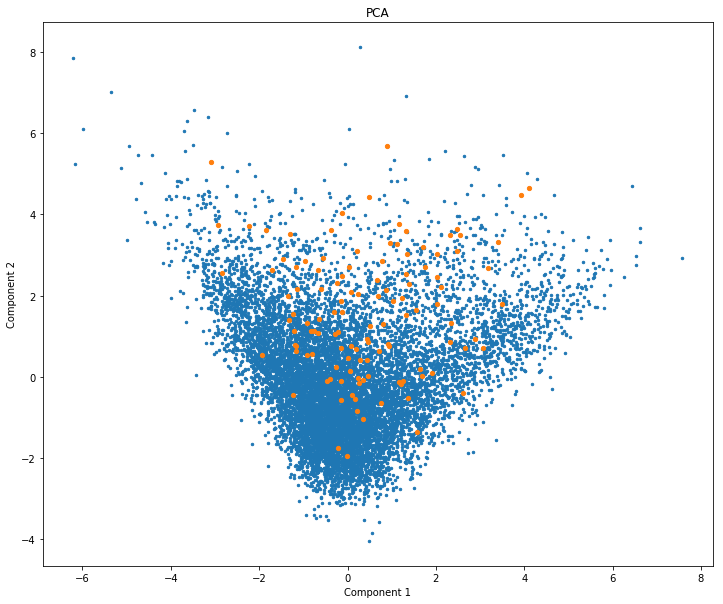

In [66]:
fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(X_t[y_labels==0,0], X_t[y_labels==0,1], color=color[0], s=6)
ax.scatter(X_t[y_labels==1,0], X_t[y_labels==1,1], color=color[1], s=18)
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [68]:
# Let's see t-SNE
from lib.tsne_mod import Plotter
plotter = Plotter()

Iteration #0 of TSNE.



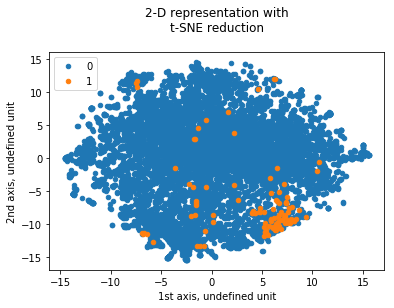

Elapsed time: 242.66331911087036
Elapsed time: 242.66354990005493


<IPython.core.display.Javascript object>

In [80]:
%%notify
start_time = time.time()

result_list = plotter.run_tsne_grid_search(X, y_labels,
                            reference_dict=None,
                            dim_red_space=2,
                            forced_perplexity=50, forced_learning_rate=1000,
                            optimi_parameter='', op_parameter_grid=[],
                            op_plot=True, op_print=True,
                            nb_outer_iterations=1)

print('Elapsed time:', time.time() - start_time)

"""
Remark, only 1 iteration of t-SNE is performed here, while in pratice we could perform 
several iterations (nb_outer_iterations>1) to lower the Kullback-Leibler (KL) divergence. 
The KL divergence measures the distance between the two distribution of probabilities.
"""

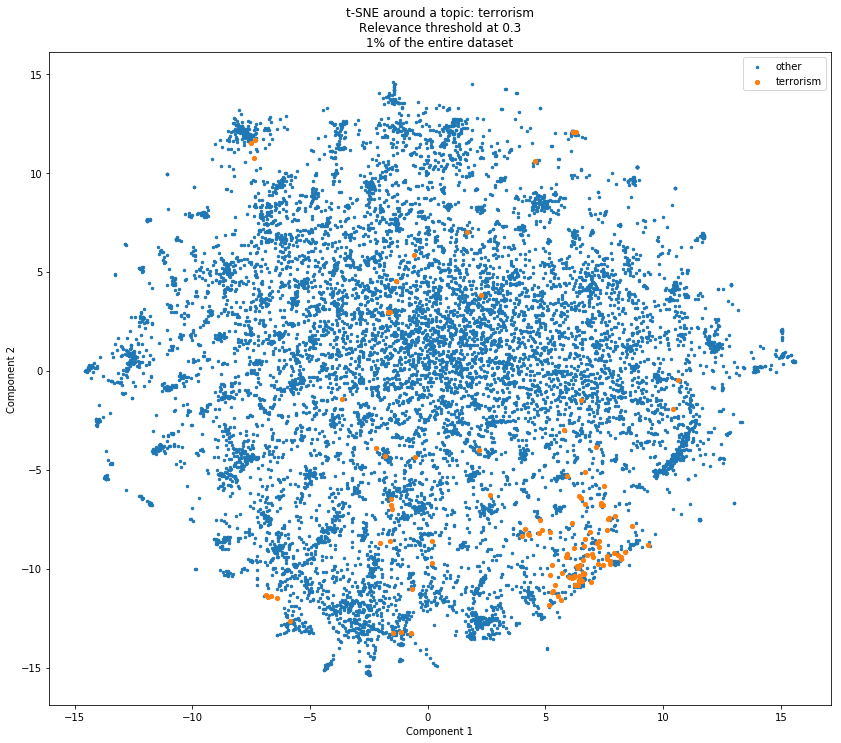

In [90]:
X_trans = result_list[0]['embeddings']
fig, ax = plt.subplots(figsize=(14,12))
ax.scatter(X_trans[y_labels==0,0], X_trans[y_labels==0,1], color=color[0], s=6)
ax.scatter(X_trans[y_labels==1,0], X_trans[y_labels==1,1], color=color[1], s=18)
plt.title('t-SNE around a topic: ' + 'terrorism\nRelevance threshold at 0.3\n1% of the entire dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(['other','terrorism'])
plt.show()

PCA is really not suitable to perform such dimensionality reduction.
t-SNE is more able to compute the reduction while preserving clusters in word2vec space.

Let's compare to a manual labelling above the threshold 0.3 

In [92]:
len(most_relevant[most_relevant['relevance_score'] > 0.3])

119

In [94]:
most_relevant[['headline_text','relevance_score','is_terror']].to_csv('./data/most_relevant_terrorism_manual.csv', index=True)

In [31]:
y_labels_manual = pd.read_csv('./data/most_relevant_terrorism_manual_windex.csv')

In [20]:
y_labels_manual = np.array(y_labels_manual['is_terror_manual'])

In [21]:
np.sum((y_labels_manual))

84

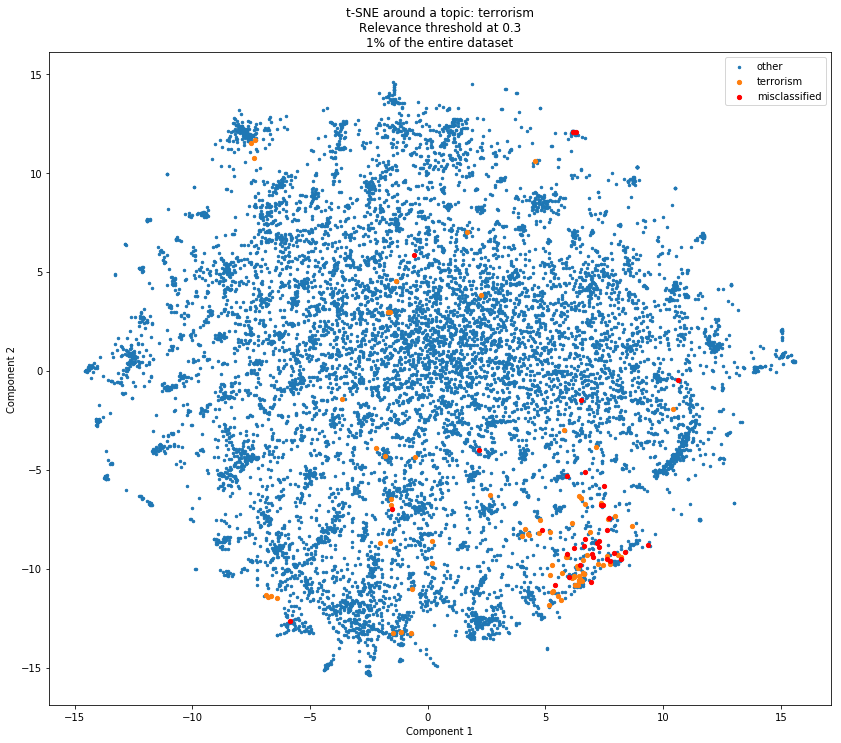

In [112]:
# Plotting with manual labels
X_trans = result_list[0]['embeddings']
fig, ax = plt.subplots(figsize=(14,12))
ax.scatter(X_trans[(y_labels_manual==0)&(y_labels==0),0], X_trans[(y_labels_manual==0)&(y_labels==0),1], color=color[0], s=6)
ax.scatter(X_trans[(y_labels_manual==1)&(y_labels==1),0], X_trans[(y_labels_manual==1)&(y_labels==1),1], color=color[1], s=18)
ax.scatter(X_trans[(y_labels_manual != y_labels),0], X_trans[(y_labels_manual != y_labels),1], color='red', s=18)
plt.title('t-SNE around a topic: ' + 'terrorism\nRelevance threshold at 0.3\n1% of the entire dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(['other','terrorism', 'misclassified'])
plt.show()

We removed 35 "misclassified" headlines.
It is not so surprising that some points from the bottom right cluster (we identify it as the terrorism cluster) were removed since we are measuring similarities to score the relevance, so points that are close in the initial space.

Our relevance scoring (based on the rule of thumb threshold 0.3) is not performing so well: precision ~ 0.7 (84/120)

A potential big improvement would be to try computing the word2vec features including the bigrams. 
Also we don't have enough labelled data to plot trends.

#### t-SNE with 10% of the dataset

It seems we had an issue with indices.
We re-computed the most_relevant dataframes in the previous ligns. 

The index for t-SNE model matrix is dX.index that we are loading is derived from:
    > df_samp = pd.read_csv('./data/abc_text_date_frac10_w2vfeat_windex.csv')
    > df_samp.index = df_samp['Unnamed: 0.1']

Checking with df_samp.headline_text.loc[882416] == 'indonesian terrorism expert says jihadists celebrating isis iraq'
    > dX = df_samp[[('feat_'+str(i)) for i in range(300)]]
    > dX = dX.dropna(how='any')
    > dX.index
        
Below, we re-compute the labels for 'terrorism' on the 10% of the dataset before plotting the t-SNE.

In [30]:
dfmerge[['headline_text', 'relevance_score']].head(10)

headline_text  \
Unnamed: 0.1                                                      
413637        germanys terrorist suspects intended to wage j...   
1055052       religious extremists not the only terror threa...   
808767                  syria bashar assad speech rebels terror   
882416        indonesian terrorism expert says jihadists cel...   
288264        identifying radicalism key to thwarting terrorism   
126650          israeli army shoots two islamic jihad militants   
895232        civil liberty groups suspect spies exaggeratin...   
896993        grand mufti muslim community radical fighters ...   
198657                 muslim community fears terrorism arrests   
950636        philippines' most wanted islamist terrorist ki...   

              relevance_score  
Unnamed: 0.1                   
413637               0.556111  
1055052              0.534246  
808767               0.532320  
882416               0.530227  
288264               0.525464  
126650               0.507478  
895232               0.501842  
896993               0.499450  
198657               0.496263  
950636               0.495034

In [31]:
# We still can use the threshold 0.3 to label headlines
len(dfmerge[dfmerge['relevance_score'] > 0.3])

1248

In [34]:
y_labels_tsne = (dfmerge['relevance_score'] > 0.3).astype(int)
y_labels_tsne.shape[0] 

110243

In [38]:
# Let's display the same reductions with t-SNE reduction performed on 10% of the dataset
# Load the embeddings from file
dfX = pd.read_csv('./lib/tsne_data_frac10/best_model_Xtran_kl_5-19.csv', header=None)
dfX = dfX.T

(110244, 2)

In [43]:
# Dropping first row
dfX = dfX.iloc[1:]
dfX.head(2)

0         1
1  1.782125  1.822528
2 -0.571092  2.058111

In [53]:
dfX.index = dX.index
dfX.head(2)

0         1
Unnamed: 0.1                    
794981        1.782125  1.822528
1021941      -0.571092  2.058111

In [50]:
X_trans = dfX.loc[y_labels_tsne.index].as_matrix()

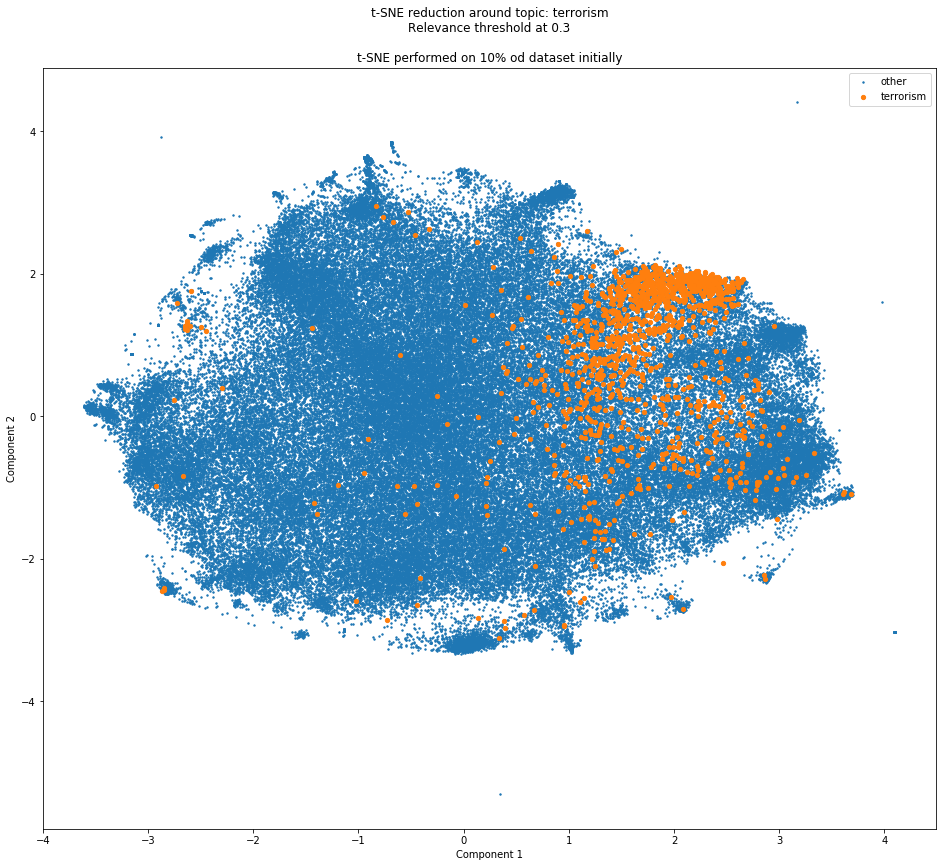

In [52]:
fig, ax = plt.subplots(figsize=(16,14))
ax.scatter(X_trans[y_labels_tsne==0,0], X_trans[y_labels_tsne==0,1], color=color[0], s=2)
ax.scatter(X_trans[y_labels_tsne==1,0], X_trans[y_labels_tsne==1,1], color=color[1], s=18)
plt.title('t-SNE reduction around topic: terrorism' + '\nRelevance threshold at 0.3\n \n' 
          + 't-SNE performed on 10% od dataset initially')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(['other','terrorism'])
plt.show()

In [54]:
dfmerge['is_terror'] = y_labels_tsne
dfmerge[['headline_text', 'publish_date', 'relevance_score','is_terror']].to_csv('./data/is_terror_reindexing_frac10.csv', index=True)